# Goals:
* associate towns (opioid overdose death rates + acs) and medicare drug spending/claim counts
* EDA on potential relationship between opioid overdose deaths and opioid or benzo claims

### Outputs:
* /data/tidy_data/medicare_partD_opioid_prescriber_all_years_no_ziptown_duplicates.csv"
* /data/tidy_data/acs_medicare_opioid_stats_death_rate.csv

In [1]:
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale=1.5)

In [2]:
death_and_acs_data = pd.read_csv("../../../data/tidy_data/death_count_norm_to_pop_and_acs_town_demographics_merge.csv")
opi_pres_13 = pd.read_csv("../../../data/tidy_data/medicare_partD_opioid_prescriber_2013_w_zip_MAtown_v1.csv").drop('Unnamed: 0', axis=1)
opi_pres_14 = pd.read_csv("../../../data/tidy_data/medicare_partD_opioid_prescriber_2014_w_zip_MAtown_v1.csv").drop('Unnamed: 0', axis=1)
opi_pres_15 = pd.read_csv("../../../data/tidy_data/medicare_partD_opioid_prescriber_2015_w_zip_MAtown_v1.csv").drop('Unnamed: 0', axis=1)
opi_pres_16 = pd.read_csv("../../../data/tidy_data/medicare_partD_opioid_prescriber_2016_w_zip_MAtown_v1.csv").drop('Unnamed: 0', axis=1)
opi_pres_17 = pd.read_csv("../../../data/tidy_data/medicare_partD_opioid_prescriber_2017_w_zip_MAtown_v1.csv").drop('Unnamed: 0', axis=1)

In [3]:
opi_pres_13.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,year
0,1003002312,hopkins,patricia,2169,quincy,MA,internal medicine,4139,522.0,12.61,104.0,2013
1,1003083270,kabadi,mitesh,2169,quincy,MA,cardiology,40,0.0,0.00,0.0,2013
2,1003834433,nair,anil,2169,quincy,MA,neurology,1217,NaN,NaN,NaN,2013
3,1003895269,angelini,domenic,2169,quincy,MA,dentist,14,0.0,0.00,0.0,2013
4,1003992397,carolan,patricia,2169,quincy,MA,dentist,37,NaN,NaN,0.0,2013


In [4]:
opi_pres_df = [opi_pres_13, opi_pres_14, opi_pres_15, opi_pres_16, opi_pres_17]

In [5]:
for x in opi_pres_df:
    print(x['nppes_provider_state'].value_counts())
for x in opi_pres_df:
    x.drop('nppes_provider_state', axis=1, inplace=True)

MA    34086
Name: nppes_provider_state, dtype: int64
MA    34734
Name: nppes_provider_state, dtype: int64
MA    35416
Name: nppes_provider_state, dtype: int64
MA    36357
Name: nppes_provider_state, dtype: int64
MA    37069
Name: nppes_provider_state, dtype: int64


In [6]:
opi_pres_13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34086 entries, 0 to 34085
Data columns (total 11 columns):
npi                               34086 non-null int64
nppes_provider_last_name          34085 non-null object
nppes_provider_first_name         34002 non-null object
nppes_provider_zip_code           34086 non-null int64
town                              34086 non-null object
specialty_description             34086 non-null object
total_claim_count                 34086 non-null int64
opioid_claim_count                22667 non-null float64
opioid_prescribing_rate           22667 non-null float64
long-acting_opioid_claim_count    28188 non-null float64
year                              34086 non-null int64
dtypes: float64(3), int64(4), object(4)
memory usage: 2.9+ MB


In [7]:
for x in opi_pres_df:
    x['nppes_provider_zip_code'] = x['nppes_provider_zip_code'].astype(str).str.zfill(5)

In [8]:
opi_pres_13.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,year
0,1003002312,hopkins,patricia,02169,quincy,internal medicine,4139,522.0,12.61,104.0,2013
1,1003083270,kabadi,mitesh,02169,quincy,cardiology,40,0.0,0.00,0.0,2013
2,1003834433,nair,anil,02169,quincy,neurology,1217,NaN,NaN,NaN,2013
3,1003895269,angelini,domenic,02169,quincy,dentist,14,0.0,0.00,0.0,2013
4,1003992397,carolan,patricia,02169,quincy,dentist,37,NaN,NaN,0.0,2013


In [9]:
opi_pres_all = pd.concat(opi_pres_df, axis=0, ignore_index=True)

In [10]:
for x in opi_pres_df:
    print(x.shape)
print(opi_pres_all.shape)

(34086, 11)
(34734, 11)
(35416, 11)
(36357, 11)
(37069, 11)
(177662, 11)


In [11]:
# according to documentation, opioid claims are redacted if claim count is between 1-10 (not zero) 
# replace with 5
opi_pres_all['opioid_claim_count'] = opi_pres_all['opioid_claim_count'].fillna(value=5.0)
opi_pres_all['calc_opioid_rate'] = (opi_pres_all['opioid_claim_count'] / opi_pres_all['total_claim_count']) * 100
opi_pres_all.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,year,calc_opioid_rate
0,1003002312,hopkins,patricia,02169,quincy,internal medicine,4139,522.0,12.61,104.0,2013,12.611742
1,1003083270,kabadi,mitesh,02169,quincy,cardiology,40,0.0,0.00,0.0,2013,0.000000
2,1003834433,nair,anil,02169,quincy,neurology,1217,5.0,NaN,NaN,2013,0.410846
3,1003895269,angelini,domenic,02169,quincy,dentist,14,0.0,0.00,0.0,2013,0.000000
4,1003992397,carolan,patricia,02169,quincy,dentist,37,5.0,NaN,0.0,2013,13.513514


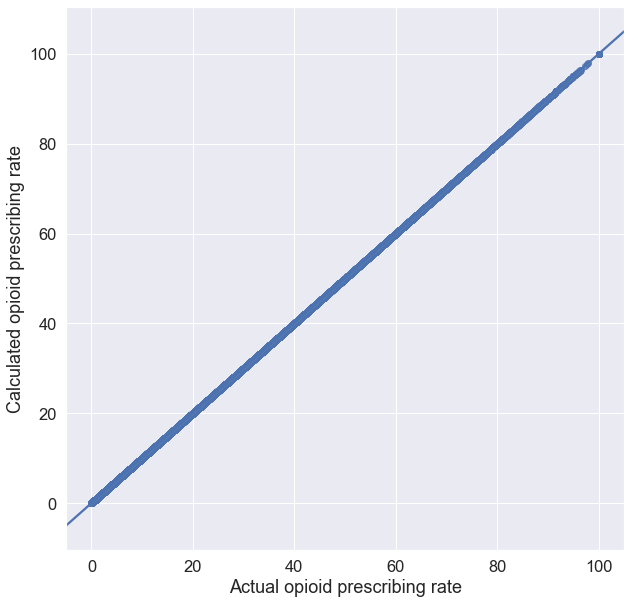

In [12]:
# was the opioid prescribing rate calculated as I expected?
plt.figure(figsize=(10,10))
sns.regplot(x='opioid_prescribing_rate', y='calc_opioid_rate', data=opi_pres_all.dropna())
plt.xlabel('Actual opioid prescribing rate')
plt.ylabel('Calculated opioid prescribing rate')
plt.show()
# A: yes

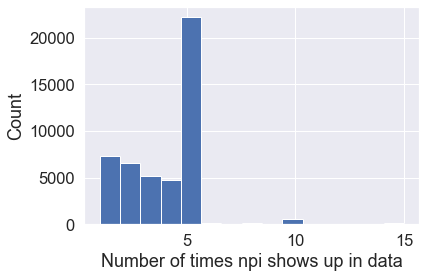

In [13]:
npi_counts = opi_pres_all['npi'].value_counts().reset_index()
npi_counts['npi'].hist(bins=15)
plt.xlabel('Number of times npi shows up in data')
plt.ylabel('Count')
plt.show()

In [14]:
npi_counts.head()

,index,npi
0,1801868161,15
1,1417060989,15
2,1265650162,15
3,1205096583,15
4,1760446140,15


In [15]:
opi_pres_all[opi_pres_all['npi'] == npi_counts.iloc[0,0]].sort_values('year')

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,year,calc_opioid_rate
20515,1801868161,costa,joseph,02467,brookline,dentist,18,5.0,NaN,0.0,2013,27.777778
20516,1801868161,costa,joseph,02467,boston,dentist,18,5.0,NaN,0.0,2013,27.777778
20517,1801868161,costa,joseph,02467,newton,dentist,18,5.0,NaN,0.0,2013,27.777778
55159,1801868161,costa,joseph,02467,brookline,dentist,25,5.0,NaN,0.0,2014,20.000000
55160,1801868161,costa,joseph,02467,boston,dentist,25,5.0,NaN,0.0,2014,20.000000
55161,1801868161,costa,joseph,02467,newton,dentist,25,5.0,NaN,0.0,2014,20.000000
90560,1801868161,costa,joseph,02467,brookline,dentist,22,5.0,NaN,0.0,2015,22.727273
90561,1801868161,costa,joseph,02467,boston,dentist,22,5.0,NaN,0.0,2015,22.727273
90562,1801868161,costa,joseph,02467,newton,dentist,22,5.0,NaN,0.0,2015,22.727273
128212,1801868161,costa,joseph,02467,brookline,dentist,14,0.0,0.0,0.0,2016,0.000000


In [16]:
npi_counts[npi_counts['npi'] > 5]

,index,npi
0,1801868161,15
1,1417060989,15
2,1265650162,15
3,1205096583,15
4,1760446140,15
...,...,...
1197,1033269782,6
1198,1205277761,6
1199,1609250406,6
1200,1154736007,6


In [17]:
opi_pres_all[opi_pres_all['npi'] == 1790044303]

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,year,calc_opioid_rate
24564,1790044303,agnoli,alicia,02148,malden,student in an organized health care education/...,87,5.0,NaN,NaN,2013,5.747126
24565,1790044303,agnoli,alicia,02148,revere,student in an organized health care education/...,87,5.0,NaN,NaN,2013,5.747126
59258,1790044303,agnoli,alicia,02148,malden,student in an organized health care education/...,369,29.0,7.86,NaN,2014,7.859079
59259,1790044303,agnoli,alicia,02148,revere,student in an organized health care education/...,369,29.0,7.86,NaN,2014,7.859079
94296,1790044303,agnoli,alicia,02148,malden,student in an organized health care education/...,470,25.0,5.32,NaN,2015,5.319149
94297,1790044303,agnoli,alicia,02148,revere,student in an organized health care education/...,470,25.0,5.32,NaN,2015,5.319149


In [18]:
len(opi_pres_all.index)

177662

In [19]:
l = random.sample(range(0,177662), 177662)

In [20]:
print(len(l))
print(len(set(l)))

177662
177662


In [21]:
opi_pres_all['sort_index'] = l

In [22]:
opi_pres_all.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,year,calc_opioid_rate,sort_index
0,1003002312,hopkins,patricia,02169,quincy,internal medicine,4139,522.0,12.61,104.0,2013,12.611742,12157
1,1003083270,kabadi,mitesh,02169,quincy,cardiology,40,0.0,0.00,0.0,2013,0.000000,2384
2,1003834433,nair,anil,02169,quincy,neurology,1217,5.0,NaN,NaN,2013,0.410846,65671
3,1003895269,angelini,domenic,02169,quincy,dentist,14,0.0,0.00,0.0,2013,0.000000,81143
4,1003992397,carolan,patricia,02169,quincy,dentist,37,5.0,NaN,0.0,2013,13.513514,26778


In [27]:
print(len(opi_pres_all[['npi', 'nppes_provider_last_name', 'nppes_provider_first_name']].drop_duplicates().index))
print(len(opi_pres_all[['npi']].drop_duplicates().index))
print(len(opi_pres_all[['npi', 'year']].drop_duplicates().index))
print(len(opi_pres_all[['npi', 'year', 'nppes_provider_last_name', 'nppes_provider_first_name']].drop_duplicates().index))

47875
47160
170744
170744


Not sure what's going on with the npi/name combos

In [28]:
opi_pres_no_zip_dup = opi_pres_all.sort_values(['npi', 'year', 'sort_index']).drop_duplicates(subset=['npi', 'year', 'nppes_provider_last_name', 'nppes_provider_first_name'], keep='last')
print(opi_pres_no_zip_dup.shape)

(170744, 13)


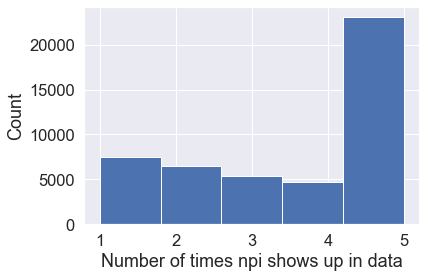

In [29]:
npi_counts_updt = opi_pres_no_zip_dup['npi'].value_counts().reset_index()
npi_counts_updt['npi'].hist(bins=5)
plt.xlabel('Number of times npi shows up in data')
plt.ylabel('Count')
plt.show()

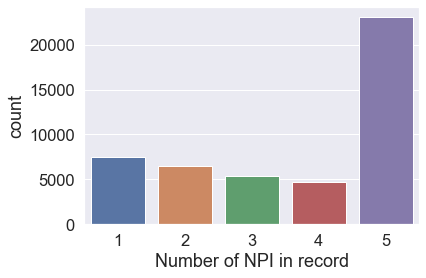

In [30]:
sns.countplot(x="npi", data=npi_counts_updt)
plt.xlabel('Number of NPI in record')
plt.show()

In [31]:
opi_pres_no_zip_dup.columns

Index(['npi', 'nppes_provider_last_name', 'nppes_provider_first_name',
       'nppes_provider_zip_code', 'town', 'specialty_description',
       'total_claim_count', 'opioid_claim_count', 'opioid_prescribing_rate',
       'long-acting_opioid_claim_count', 'year', 'calc_opioid_rate',
       'sort_index'],
      dtype='object')

In [32]:
opi_pres_no_zip_dup.drop(['long-acting_opioid_claim_count', 'opioid_prescribing_rate', 'sort_index'], axis=1, inplace=True)
opi_pres_no_zip_dup.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,specialty_description,total_claim_count,opioid_claim_count,year,calc_opioid_rate
34086,1003001660,newton,robert,02446,brookline,urology,12,0.0,2014,0.000000
0,1003002312,hopkins,patricia,02169,quincy,internal medicine,4139,522.0,2013,12.611742
34365,1003002312,hopkins,patricia,02169,quincy,internal medicine,4467,542.0,2014,12.133423
68820,1003002312,hopkins,patricia,02169,quincy,internal medicine,4183,495.0,2015,11.833612
104236,1003002312,hopkins,patricia,02169,quincy,rheumatology,4634,593.0,2016,12.796720


In [33]:
# to keep zeroes in zipcode when writing
opi_pres_no_zip_dup['nppes_provider_zip_code'] = opi_pres_no_zip_dup['nppes_provider_zip_code'].astype('str')

In [34]:
death_and_acs_data

,city_death,tot_pop_17,over_65_count,over_65_prop,med_house_inc,mean_house_inc,mean_med_inc_desp,drop_out,less_than_hs_ed,at_or_below_pov_prop,pop_struggling_prop,town_status,urb_v_rur,death_rate_12,death_rate_13,death_rate_14,death_rate_15,death_rate_16,death_rate_17,death_rate_18
0,abington,16275,2469,0.151705,87156.000000,98809.035505,11653.035505,3.452855,5.405643,0.035754,0.100408,grown,rural,0.622361,1.241520,0.000000,3.705501,0.616007,1.843318,3.064396
1,acton,23455,4001,0.170582,139890.466667,156680.203867,16789.737200,1.219512,2.456531,0.038315,0.041747,grown,rural,0.894397,0.000000,0.438618,0.868901,1.291084,0.000000,0.422409
2,acushnet,10443,2431,0.232788,69624.714286,80333.175842,10708.461556,10.992908,18.297315,0.040828,0.178406,grown,rural,1.933675,0.000000,0.000000,3.845045,1.918833,3.830317,0.000000
3,adams,8211,1764,0.214834,48445.400000,60968.594660,12523.194660,6.906907,11.862182,0.110854,0.144597,shrunk,rural,1.189525,1.195090,2.401413,3.619130,1.212100,0.000000,4.894848
4,agawam,27769,6195,0.223090,65490.125000,79464.234446,13974.109446,0.000000,7.748863,0.094819,0.142656,shrunk,rural,0.354022,1.065671,0.356434,0.715304,0.000000,1.440455,2.890860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,winthrop,18462,4114,0.222836,75567.000000,95947.051705,20380.051705,2.687412,5.598220,0.082171,0.111967,grown,rural,3.938622,1.116659,0.000000,1.099730,0.545728,4.874878,1.075277
343,woburn,39500,7595,0.192278,84871.428571,98642.691942,13771.263371,3.173804,5.676144,0.059830,0.108290,grown,rural,1.557864,1.549930,1.285064,0.255717,2.289910,2.531646,2.015258
344,worcester,184743,26267,0.142181,52213.955556,65734.403488,14222.791135,2.574476,15.274429,0.217695,0.196946,grown,urban,1.317946,2.354489,4.695396,6.532872,5.917008,6.387251,7.232637
345,wrentham,11597,1814,0.156420,109280.000000,133462.931270,24182.931270,3.359173,3.251092,0.050582,0.058336,grown,rural,0.897793,0.000000,0.883247,1.752300,0.869166,1.724584,0.855526


In [35]:
print(len(set(death_and_acs_data['city_death']) - set(opi_pres_no_zip_dup['town'])))
print(len(set(opi_pres_no_zip_dup['town']) - set(death_and_acs_data['city_death'])))

54
3


In [36]:
set(opi_pres_no_zip_dup['town']) - set(death_and_acs_data['city_death'])

{'manchester by the sea', 'monroe', 'worthington'}

In [37]:
set(death_and_acs_data['city_death']) - set(opi_pres_no_zip_dup['town'])

{'acushnet',
 'alford',
 'aquinnah',
 'ashby',
 'becket',
 'blandford',
 'cheshire',
 'chesterfield',
 'clarksburg',
 'colrain',
 'dunstable',
 'east brookfield',
 'erving',
 'florida',
 'gill',
 'gosnold',
 'granby',
 'granville',
 'hancock',
 'hawley',
 'heath',
 'hinsdale',
 'holland',
 'leyden',
 'manchester',
 'middlefield',
 'millville',
 'montgomery',
 'mount washington',
 'nahant',
 'new ashford',
 'new braintree',
 'new marlborough',
 'new salem',
 'northfield',
 'oakham',
 'pelham',
 'peru',
 'petersham',
 'phillipston',
 'plainfield',
 'plympton',
 'rowe',
 'royalston',
 'russell',
 'sandisfield',
 'savoy',
 'tolland',
 'tyringham',
 'wales',
 'warwick',
 'washington',
 'wendell',
 'westhampton'}

In [38]:
opi_pres_no_zip_dup['town'] = opi_pres_no_zip_dup['town'].str.replace('manchester by the sea', 'manchester')

In [39]:
set(opi_pres_no_zip_dup['town']) - set(death_and_acs_data['city_death'])

{'monroe', 'worthington'}

In [40]:
#opi_pres_no_zip_dup.to_csv("../../../data/tidy_data/medicare_partD_opioid_prescriber_all_years_no_ziptown_duplicates.csv", index=False)

In [41]:
opi_pres_no_zip_dup.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,specialty_description,total_claim_count,opioid_claim_count,year,calc_opioid_rate
34086,1003001660,newton,robert,02446,brookline,urology,12,0.0,2014,0.000000
0,1003002312,hopkins,patricia,02169,quincy,internal medicine,4139,522.0,2013,12.611742
34365,1003002312,hopkins,patricia,02169,quincy,internal medicine,4467,542.0,2014,12.133423
68820,1003002312,hopkins,patricia,02169,quincy,internal medicine,4183,495.0,2015,11.833612
104236,1003002312,hopkins,patricia,02169,quincy,rheumatology,4634,593.0,2016,12.796720


In [47]:
opi_pres_mean_stats = opi_pres_no_zip_dup.groupby(['town', 'year']).mean().reset_index().drop('npi', axis=1)
opi_pres_mean_stats.columns = ['town', 'year', 'total_claims_count_avg', 'opioid_claim_count_avg', 'opioid_rate_avg']
opi_pres_mean_stats.head()

,town,year,total_claims_count_avg,opioid_claim_count_avg,opioid_rate_avg
0,abington,2013,2179.083333,89.666667,7.123603
1,abington,2014,1925.350000,79.700000,7.807532
2,abington,2015,2408.916667,64.041667,6.627004
3,abington,2016,2871.857143,72.333333,4.429928
4,abington,2017,2498.826087,67.434783,5.274131


In [49]:
opi_pres_sum_stats = opi_pres_no_zip_dup.groupby(['town', 'year']).sum().reset_index().drop(['npi', 'calc_opioid_rate'], axis=1)
opi_pres_sum_stats.columns = ['town', 'year', 'total_claim_count_sum', 'opioid_claim_count_sum']
opi_pres_sum_stats.head()

,town,year,total_claim_count_sum,opioid_claim_count_sum
0,abington,2013,52298,2152.0
1,abington,2014,38507,1594.0
2,abington,2015,57814,1537.0
3,abington,2016,60309,1519.0
4,abington,2017,57473,1551.0


In [52]:
print(opi_pres_mean_stats.shape)
print(opi_pres_sum_stats.shape)
opi_pres_stats = opi_pres_mean_stats.merge(opi_pres_sum_stats, on=['town', 'year'], how='inner')
print(opi_pres_stats.shape)
display(opi_pres_stats.head())
display(opi_pres_stats.describe())

(1438, 5)
(1438, 4)
(1438, 7)


,town,year,total_claims_count_avg,opioid_claim_count_avg,opioid_rate_avg,total_claim_count_sum,opioid_claim_count_sum
0,abington,2013,2179.083333,89.666667,7.123603,52298,2152.0
1,abington,2014,1925.350000,79.700000,7.807532,38507,1594.0
2,abington,2015,2408.916667,64.041667,6.627004,57814,1537.0
3,abington,2016,2871.857143,72.333333,4.429928,60309,1519.0
4,abington,2017,2498.826087,67.434783,5.274131,57473,1551.0


,year,total_claims_count_avg,opioid_claim_count_avg,opioid_rate_avg,total_claim_count_sum,opioid_claim_count_sum
count,1438.000000,1438.000000,1438.000000,1438.000000,1.438000e+03,1438.000000
mean,2014.995132,1368.366165,61.048364,8.856701,1.122620e+05,4723.317803
std,1.413467,1031.772994,56.621581,6.175832,3.413563e+05,14546.384508
min,2013.000000,11.000000,0.000000,0.000000,1.100000e+01,0.000000
25%,2014.000000,790.629670,27.251136,5.325307,1.087675e+04,420.250000
50%,2015.000000,1226.000000,48.902206,8.091398,3.376600e+04,1396.500000
75%,2016.000000,1707.300826,76.386719,11.058857,9.881100e+04,4184.000000
max,2017.000000,8922.636364,555.500000,69.696970,5.442227e+06,209604.000000


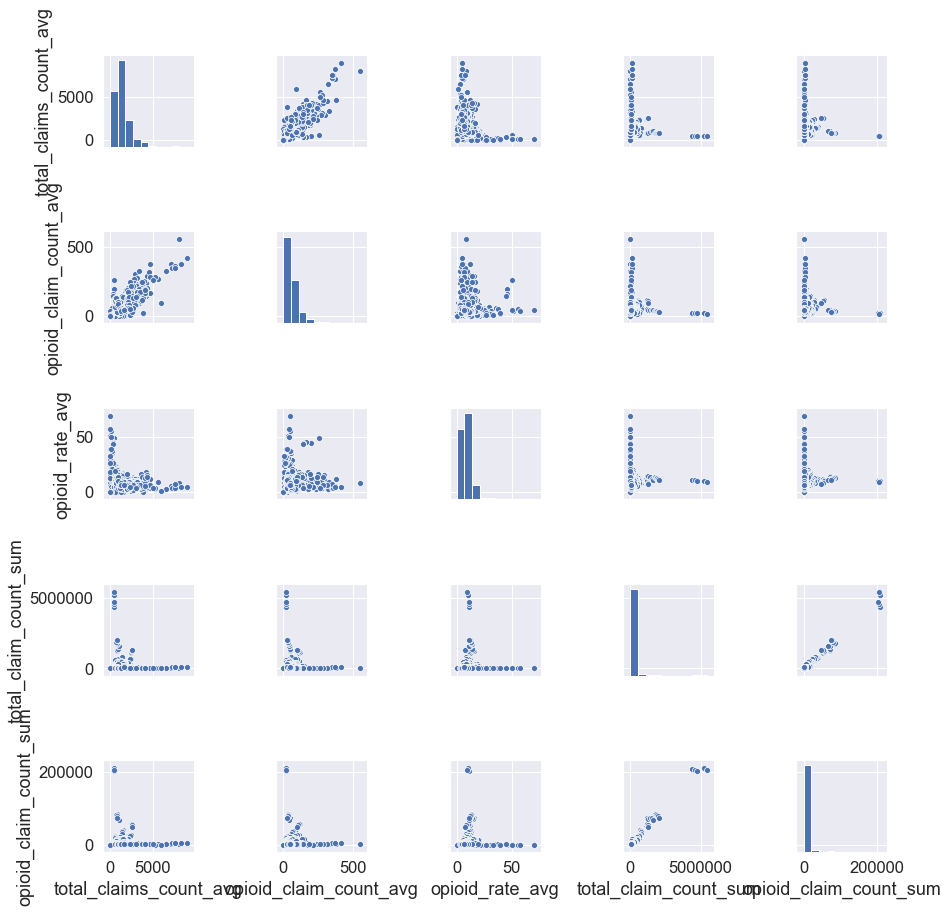

In [54]:
sns.pairplot(opi_pres_stats.drop(['town', 'year'], axis=1))

In [61]:
opi_pres_stats[opi_pres_stats['total_claim_count_sum'] > 2000000]

,town,year,total_claims_count_avg,opioid_claim_count_avg,opioid_rate_avg,total_claim_count_sum,opioid_claim_count_sum
144,boston,2013,436.120317,20.636274,11.472438,4400454,208220.0
145,boston,2014,447.212293,20.033951,11.057803,4583926,205348.0
146,boston,2015,453.524232,19.308529,10.666161,4753841,202392.0
147,boston,2016,474.821885,19.145415,10.180812,5198350,209604.0
148,boston,2017,479.280229,18.064465,9.217205,5442227,205122.0
1422,worcester,2017,806.286672,29.255915,10.768587,2044743,74193.0


In [82]:
year_dict = {'death_rate_12': 2011, 'death_rate_13': 2012, 'death_rate_14': 2013, 'death_rate_15': 2014,
    'death_rate_16': 2015, 'death_rate_17': 2016, 'death_rate_18': 2017}
city_year_death_long = pd.melt(death_and_acs_data, id_vars=['city_death'], value_vars=[
    'death_rate_12', 'death_rate_13', 'death_rate_14', 'death_rate_15',
    'death_rate_16', 'death_rate_17', 'death_rate_18'
]).replace({"variable": year_dict})
city_year_death_long.columns = ['city_death', 'year', 'death_rate_per10k']
display(city_year_death_long.head())

,city_death,year,death_rate_per10k
0,abington,2011,0.622361
1,acton,2011,0.894397
2,acushnet,2011,1.933675
3,adams,2011,1.189525
4,agawam,2011,0.354022


In [83]:
print(city_year_death_long.shape)
print(death_and_acs_data.shape)
death_and_acs_long = city_year_death_long.merge(death_and_acs_data.drop(['death_rate_12', 'death_rate_13', 'death_rate_14', 'death_rate_15', 'death_rate_16', 'death_rate_17', 'death_rate_18'], axis=1), on="city_death")
print(death_and_acs_long.shape)
death_and_acs_long.head()

(2429, 3)
(347, 20)
(2429, 15)


,city_death,year,death_rate_per10k,tot_pop_17,over_65_count,over_65_prop,med_house_inc,mean_house_inc,mean_med_inc_desp,drop_out,less_than_hs_ed,at_or_below_pov_prop,pop_struggling_prop,town_status,urb_v_rur
0,abington,2011,0.622361,16275,2469,0.151705,87156.0,98809.035505,11653.035505,3.452855,5.405643,0.035754,0.100408,grown,rural
1,abington,2012,1.241520,16275,2469,0.151705,87156.0,98809.035505,11653.035505,3.452855,5.405643,0.035754,0.100408,grown,rural
2,abington,2013,0.000000,16275,2469,0.151705,87156.0,98809.035505,11653.035505,3.452855,5.405643,0.035754,0.100408,grown,rural
3,abington,2014,3.705501,16275,2469,0.151705,87156.0,98809.035505,11653.035505,3.452855,5.405643,0.035754,0.100408,grown,rural
4,abington,2015,0.616007,16275,2469,0.151705,87156.0,98809.035505,11653.035505,3.452855,5.405643,0.035754,0.100408,grown,rural


In [84]:
print(opi_pres_stats.shape)
acs_death_and_opi_pres = death_and_acs_long.merge(opi_pres_stats, how="inner", left_on=["city_death", "year"], right_on=["town", "year"])
print(acs_death_and_opi_pres.shape)
display(acs_death_and_opi_pres.head())
display(acs_death_and_opi_pres.describe())

(1438, 7)
(1428, 21)


,city_death,year,death_rate_per10k,tot_pop_17,over_65_count,over_65_prop,med_house_inc,mean_house_inc,mean_med_inc_desp,drop_out,...,at_or_below_pov_prop,pop_struggling_prop,town_status,urb_v_rur,town,total_claims_count_avg,opioid_claim_count_avg,opioid_rate_avg,total_claim_count_sum,opioid_claim_count_sum
0,abington,2013,0.000000,16275,2469,0.151705,87156.0,98809.035505,11653.035505,3.452855,...,0.035754,0.100408,grown,rural,abington,2179.083333,89.666667,7.123603,52298,2152.0
1,abington,2014,3.705501,16275,2469,0.151705,87156.0,98809.035505,11653.035505,3.452855,...,0.035754,0.100408,grown,rural,abington,1925.350000,79.700000,7.807532,38507,1594.0
2,abington,2015,0.616007,16275,2469,0.151705,87156.0,98809.035505,11653.035505,3.452855,...,0.035754,0.100408,grown,rural,abington,2408.916667,64.041667,6.627004,57814,1537.0
3,abington,2016,1.843318,16275,2469,0.151705,87156.0,98809.035505,11653.035505,3.452855,...,0.035754,0.100408,grown,rural,abington,2871.857143,72.333333,4.429928,60309,1519.0
4,abington,2017,3.064396,16275,2469,0.151705,87156.0,98809.035505,11653.035505,3.452855,...,0.035754,0.100408,grown,rural,abington,2498.826087,67.434783,5.274131,57473,1551.0


,year,death_rate_per10k,tot_pop_17,over_65_count,over_65_prop,med_house_inc,mean_house_inc,mean_med_inc_desp,drop_out,less_than_hs_ed,at_or_below_pov_prop,pop_struggling_prop,total_claims_count_avg,opioid_claim_count_avg,opioid_rate_avg,total_claim_count_sum,opioid_claim_count_sum
count,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1.428000e+03,1428.000000
mean,2014.995098,1.733554,23269.595938,4087.070728,0.202919,91050.875142,112834.042914,21783.683044,2.393748,6.597659,0.073977,0.102210,1370.942198,60.941325,8.823179,1.129176e+05,4747.203081
std,1.413462,2.079226,44840.436313,6014.409427,0.065342,30176.605424,41695.447804,15913.157560,3.748634,4.993370,0.049453,0.052502,1034.683050,56.786610,6.174974,3.424591e+05,14594.418466
min,2013.000000,0.000000,446.000000,96.000000,0.086886,38909.750000,50750.537570,2129.112803,0.000000,0.354019,0.005354,0.010566,11.000000,0.000000,0.000000,1.100000e+01,0.000000
25%,2014.000000,0.000000,7117.000000,1419.000000,0.165207,70220.250000,86561.728307,12725.573046,0.000000,3.135615,0.042231,0.063789,789.810225,26.999220,5.312575,1.080225e+04,415.750000
50%,2015.000000,1.101811,13855.000000,2692.000000,0.188014,86875.000000,102959.957747,17116.689304,1.006923,5.363993,0.059686,0.090870,1229.965190,48.634430,8.071573,3.400650e+04,1405.000000
75%,2016.000000,2.466260,26823.000000,5009.000000,0.222270,106846.681818,128540.605810,24222.601387,3.278689,8.302169,0.094519,0.130955,1714.009832,75.919167,10.989267,9.939450e+04,4237.750000
max,2017.000000,15.974441,668541.000000,85040.000000,0.473703,203026.750000,316351.858774,113325.108774,30.000000,32.336132,0.332260,0.304869,8922.636364,555.500000,69.696970,5.442227e+06,209604.000000


In [85]:
acs_death_and_opi_pres['claim_per_65_and_over'] = acs_death_and_opi_pres['total_claim_count_sum'] / acs_death_and_opi_pres['over_65_count']
acs_death_and_opi_pres['opi_claim_per_65_and_over'] = acs_death_and_opi_pres['opioid_claim_count_sum'] / acs_death_and_opi_pres['over_65_count']
acs_death_and_opi_pres[['claim_per_65_and_over', 'opi_claim_per_65_and_over']].describe()

,claim_per_65_and_over,opi_claim_per_65_and_over
count,1428.000000,1428.000000
mean,18.366112,0.804856
std,17.571084,0.840314
min,0.010885,0.000000
25%,5.762441,0.208941
50%,13.827601,0.530764
75%,26.006282,1.132716
max,123.727848,5.591346


In [86]:
acs_death_and_opi_pres.columns

Index(['city_death', 'year', 'death_rate_per10k', 'tot_pop_17',
       'over_65_count', 'over_65_prop', 'med_house_inc', 'mean_house_inc',
       'mean_med_inc_desp', 'drop_out', 'less_than_hs_ed',
       'at_or_below_pov_prop', 'pop_struggling_prop', 'town_status',
       'urb_v_rur', 'town', 'total_claims_count_avg', 'opioid_claim_count_avg',
       'opioid_rate_avg', 'total_claim_count_sum', 'opioid_claim_count_sum',
       'claim_per_65_and_over', 'opi_claim_per_65_and_over'],
      dtype='object')

In [89]:
opi_and_death_stats = acs_death_and_opi_pres[['city_death', 'year', 'death_rate_per10k', 'total_claims_count_avg', 'opioid_claim_count_avg',
       'opioid_rate_avg', 'total_claim_count_sum', 'opioid_claim_count_sum',
       'claim_per_65_and_over', 'opi_claim_per_65_and_over']].copy()
opi_and_death_stats.head()

,city_death,year,death_rate_per10k,total_claims_count_avg,opioid_claim_count_avg,opioid_rate_avg,total_claim_count_sum,opioid_claim_count_sum,claim_per_65_and_over,opi_claim_per_65_and_over
0,abington,2013,0.000000,2179.083333,89.666667,7.123603,52298,2152.0,21.181855,0.871608
1,abington,2014,3.705501,1925.350000,79.700000,7.807532,38507,1594.0,15.596193,0.645606
2,abington,2015,0.616007,2408.916667,64.041667,6.627004,57814,1537.0,23.415958,0.622519
3,abington,2016,1.843318,2871.857143,72.333333,4.429928,60309,1519.0,24.426488,0.615229
4,abington,2017,3.064396,2498.826087,67.434783,5.274131,57473,1551.0,23.277845,0.628190


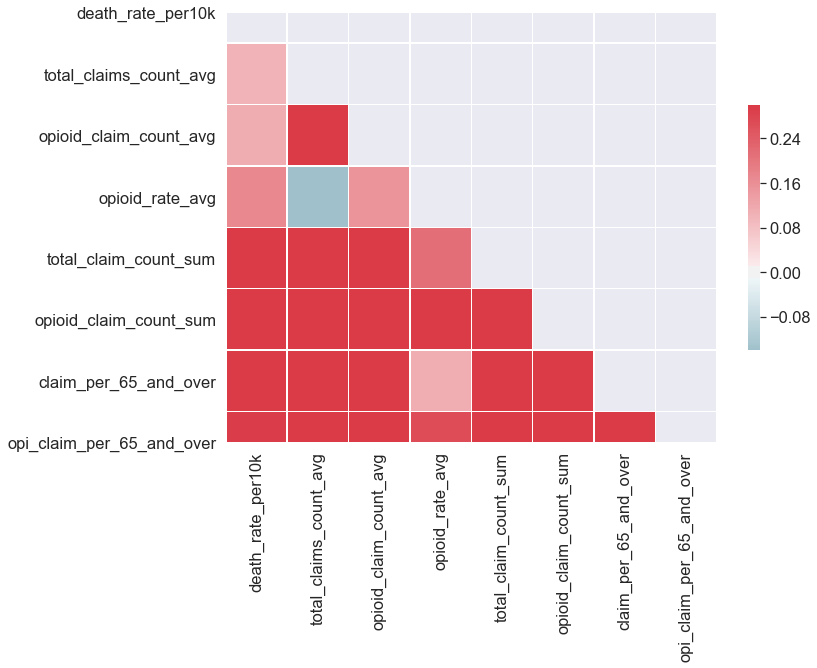

In [93]:
opi_death_rate_corr = opi_and_death_stats.drop(['city_death', 'year'], axis=1).corr(method="spearman")
# Generate a mask for the upper triangle
mask = np.zeros_like(opi_death_rate_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(opi_death_rate_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [96]:
opi_death_rate_corr[['death_rate_per10k']]

,death_rate_per10k
death_rate_per10k,1.000000
total_claims_count_avg,0.102671
opioid_claim_count_avg,0.113558
opioid_rate_avg,0.173038
total_claim_count_sum,0.432325
opioid_claim_count_sum,0.430813
claim_per_65_and_over,0.310250
opi_claim_per_65_and_over,0.294367


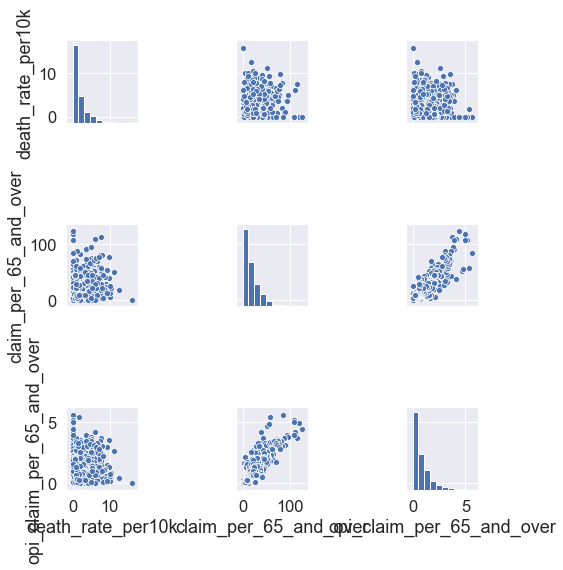

In [106]:
sns.pairplot(opi_and_death_stats[['death_rate_per10k', 'claim_per_65_and_over', 'opi_claim_per_65_and_over']])

<Figure size 1008x1008 with 0 Axes>

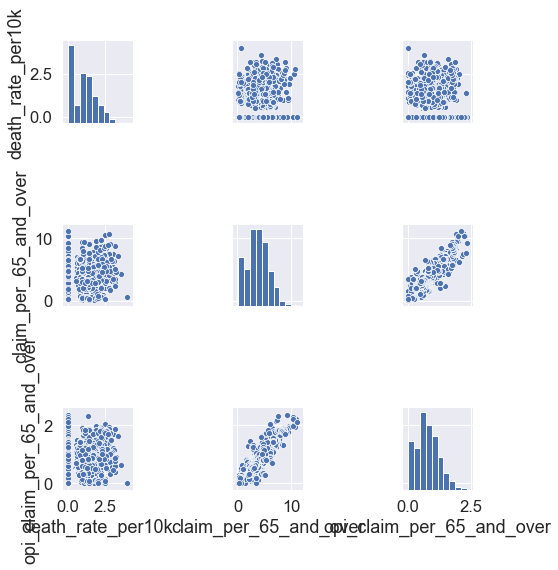

In [108]:
sns.pairplot(opi_and_death_stats[['death_rate_per10k', 'claim_per_65_and_over', 'opi_claim_per_65_and_over']].apply(np.sqrt))

In [110]:
acs_death_and_opi_pres.head()

,city_death,year,death_rate_per10k,tot_pop_17,over_65_count,over_65_prop,med_house_inc,mean_house_inc,mean_med_inc_desp,drop_out,...,town_status,urb_v_rur,town,total_claims_count_avg,opioid_claim_count_avg,opioid_rate_avg,total_claim_count_sum,opioid_claim_count_sum,claim_per_65_and_over,opi_claim_per_65_and_over
0,abington,2013,0.000000,16275,2469,0.151705,87156.0,98809.035505,11653.035505,3.452855,...,grown,rural,abington,2179.083333,89.666667,7.123603,52298,2152.0,21.181855,0.871608
1,abington,2014,3.705501,16275,2469,0.151705,87156.0,98809.035505,11653.035505,3.452855,...,grown,rural,abington,1925.350000,79.700000,7.807532,38507,1594.0,15.596193,0.645606
2,abington,2015,0.616007,16275,2469,0.151705,87156.0,98809.035505,11653.035505,3.452855,...,grown,rural,abington,2408.916667,64.041667,6.627004,57814,1537.0,23.415958,0.622519
3,abington,2016,1.843318,16275,2469,0.151705,87156.0,98809.035505,11653.035505,3.452855,...,grown,rural,abington,2871.857143,72.333333,4.429928,60309,1519.0,24.426488,0.615229
4,abington,2017,3.064396,16275,2469,0.151705,87156.0,98809.035505,11653.035505,3.452855,...,grown,rural,abington,2498.826087,67.434783,5.274131,57473,1551.0,23.277845,0.628190


In [113]:
acs_death_and_opi_pres.drop('town', axis=1, inplace=True)

In [114]:
#acs_death_and_opi_pres.to_csv("../../../data/tidy_data/acs_medicare_opioid_stats_death_rate.csv", index=False)